In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ALLCools.dmr.rms_test import permute_root_mean_square_test
from concurrent.futures import ProcessPoolExecutor, as_completed

In [3]:
# init numba
permute_root_mean_square_test(np.array([[0, 1], [0, 1]]))

1.0

In [4]:
coverages = np.arange(5, 201, 40)[::-1]
n_permutes = np.arange(1000, 15000, 2000)[::-1]
n_samples = np.arange(2, 101, 30)[::-1]
n_test = 50


def run_tests(n_sample, coverage, n_permute):
    ps = []
    # repeat to get robust stats of p_values
    for i in range(n_test):
        true_fracs = np.random.uniform(low=0.8, high=0.9, size=n_sample)
        cov = np.random.uniform(low=coverage / 3,
                                high=coverage * 3,
                                size=true_fracs.size).astype(int)
        mc = np.random.binomial(cov, p=true_fracs)
        unc = cov - mc
        table = np.array([mc, unc]).T
        # the methylpy RMS test
        p = permute_root_mean_square_test(table, n_permute=n_permute)
        ps.append(p)
    return np.array(ps)


with ProcessPoolExecutor(48) as exe:
    futures = {}
    results = {}
    for n_sample in n_samples:
        for coverage in coverages:
            for n_permute in n_permutes:
                f = exe.submit(run_tests, 
                               n_sample=n_sample, 
                               coverage=coverage, 
                               n_permute=n_permute)
                futures[f] = (n_sample, coverage, n_permute)

    for f in as_completed(futures):
        key = futures[f]
        print(key)
        results[key] = f.result()

(92, 5, 3000)
(92, 5, 1000)
(92, 5, 5000)
(92, 5, 7000)
(92, 45, 1000)
(92, 5, 9000)
(92, 5, 11000)
(92, 5, 13000)
(92, 45, 3000)
(92, 45, 5000)
(62, 85, 1000)
(92, 45, 7000)
(92, 45, 9000)
(62, 45, 13000)
(92, 85, 1000)
(62, 45, 9000)
(62, 45, 11000)
(62, 45, 1000)
(62, 45, 7000)
(62, 5, 13000)
(62, 5, 7000)
(62, 5, 11000)
(62, 5, 1000)
(62, 5, 9000)
(62, 5, 3000)
(62, 5, 5000)
(92, 45, 11000)
(62, 45, 3000)
(62, 45, 5000)
(92, 45, 13000)
(62, 85, 3000)
(62, 125, 1000)
(62, 85, 5000)
(32, 165, 1000)
(92, 85, 3000)
(62, 85, 7000)
(62, 165, 1000)
(92, 125, 1000)
(32, 125, 1000)
(62, 85, 9000)
(92, 85, 5000)
(62, 85, 11000)
(32, 125, 3000)
(32, 85, 1000)
(32, 85, 7000)
(62, 85, 13000)
(32, 85, 3000)
(32, 125, 5000)
(32, 85, 9000)
(32, 45, 9000)
(32, 45, 3000)
(32, 45, 7000)
(32, 45, 11000)
(32, 45, 1000)
(32, 45, 5000)
(32, 5, 13000)
(32, 5, 11000)
(32, 5, 9000)
(32, 5, 1000)
(32, 5, 5000)
(32, 5, 3000)
(32, 5, 7000)
(92, 165, 1000)
(2, 165, 3000)
(32, 45, 13000)
(2, 165, 1000)
(2, 165, 

In [5]:
data = pd.DataFrame(results).T.stack().reset_index()
data.columns = ['n_sample', 'coverage', 'n_permute', 'sample', 'pvalue']
data.head()

,n_sample,coverage,n_permute,sample,pvalue
0,92,5,3000,0,1.000000
1,92,5,3000,1,1.000000
2,92,5,3000,2,1.000000
3,92,5,3000,3,1.000000
4,92,5,3000,4,0.990385


In [6]:
pass_cutoff = data.groupby(
    ['n_sample', 'coverage',
     'n_permute'])['pvalue'].apply(lambda i: (i < 0.003).sum()).reset_index()

In [7]:
pass_cutoff.head()

,n_sample,coverage,n_permute,pvalue
0,2,5,1000,0
1,2,5,3000,0
2,2,5,5000,0
3,2,5,7000,0
4,2,5,9000,0


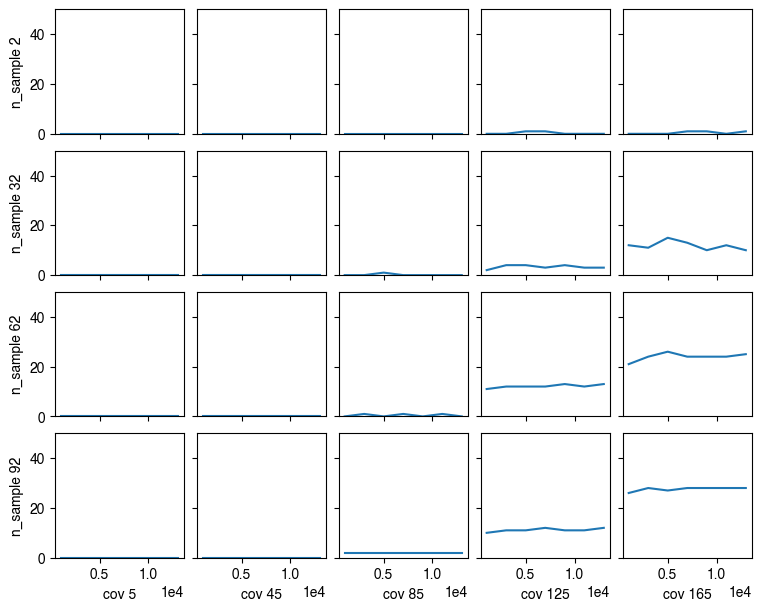

In [10]:
# Initialize a grid of plots with an Axes for each walk
ncols = coverages.size
nrows = n_samples.size
fig, axes = plt.subplots(figsize=(ncols*1.5, nrows*1.5),
                         ncols=ncols,
                         nrows=nrows,
                         dpi=100, 
                         sharex=True, 
                         sharey=True,
                         constrained_layout=True)

for col, coverage in enumerate(coverages[::-1]):
    for row, n_sample in enumerate(n_samples[::-1]):
        ax = axes[row, col]
        sns.lineplot(data=pass_cutoff[(pass_cutoff['n_sample'] == n_sample)
                                      & (pass_cutoff['coverage'] == coverage)],
                     x='n_permute',
                     y='pvalue',
                     ax=ax)
        if ax.get_subplotspec().is_last_row():
            ax.set(xlabel=f"cov {coverage}")
            ax.ticklabel_format(axis='x', scilimits=(0, 0))
        if ax.get_subplotspec().is_first_col():
            ax.set(ylabel=f"n_sample {n_sample}")
        ax.set(ylim=(0, n_test))